In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from io import BytesIO, StringIO
#get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
from google.cloud import storage
client = storage.Client()
export_bucket = client.get_bucket('0-kkbox_bucket')

In [3]:
import os
#os.system('gsutil cp gs://1-kkbox_bucket/cedar-context-387217-316d6c83570b.json .')
os.environ[ "GOOGLE_APPLICATION_CREDENTIALS"] = "/home/liangyumailbox/.config/gcloud/application_default_credentials.json"

from google.cloud import bigquery
bigquery_client = bigquery.Client()

In [4]:
df_train = pd.read_csv('gs://0-kkbox_bucket/train_v2.csv')
df_member = pd.read_csv('gs://0-kkbox_bucket/members_v3.csv')
df_transaction = pd.read_csv('gs://0-kkbox_bucket/transactions.csv')
df_transaction_2 = pd.read_csv('gs://0-kkbox_bucket/transactions_v2.csv')
df_submission = pd.read_csv('gs://0-kkbox_bucket/sample_submission_v2.csv')

In [5]:
all_df_transaction = pd.concat([df_transaction , df_transaction_2], axis=0)

In [6]:
## shape of the main dataframe
print(f"train:{df_train.shape}")
print(f"member:{df_member.shape}")
print(f"transaction:{all_df_transaction.shape}")
print(f"submission(test):{df_submission.shape}")

train:(970960, 2)
member:(6769473, 6)
transaction:(22978755, 9)
submission(test):(907471, 2)


常用的圖表公式

In [7]:
# barplot圖表
def barplot_type_percentage(data, col1, xname, yname, fig, col2, temp, percentage):
    '''This function is used to plot a count plot, with percentage displayed on top of each bin'''
    fig,axes = plt.subplots(figsize=fig)
    sns.barplot(data=data, x=data[col1], y=data[col2],order=temp[col1])
    plt.xticks(size=10)
    plt.xlabel(xname, size=12)
    plt.yticks(size=10)
    plt.ylabel(yname, size=12)
    #axes.yaxis.set_major_formatter(PercentFormatter(1))
    
    i=0
    for p in axes.patches:
        x = p.get_x()
        y = p.get_height()*1.02
        #percentage = 
        axes.annotate(str(percentage[i])+'%', (x, y), ha='center', size=10)
        i+=1
    plt.show()

In [8]:
# barplot圖表說明
def barplot_analysis(data, col1, xname, yname, fig, col2):
    temp = data.groupby(col1)[col2].agg('sum').reset_index()
    temp['total_users'] = data.groupby(col1)[col2].agg(total_users='count').reset_index()['total_users']
    temp['churned_ratio'] = data.groupby(col1)[col2].agg(churned_ratio='mean').reset_index()['churned_ratio']
    #temp['churned_ratio'] = temp['is_churn']/data[col1].count()
    temp = temp.sort_values(by=['churned_ratio']).reset_index(drop=True)
    percentage = np.round(temp['churned_ratio']*100,2)
    
    barplot_type_percentage(data, col1, xname, yname, fig, col2, temp, percentage)
    print(temp)

##### EDA: Analysis on members data

##### 合併這次會使用到的資料集

In [9]:
# merging train dataset with members dataset
train_member = df_train.merge(df_member,on='msno',how='left')

In [10]:
train_member.head(5)

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,20131223.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,20131227.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,20140109.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,20140125.0


In [11]:
#確認train_member的摘要、是否有空值
train_member.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    970960 non-null  object 
 1   is_churn                970960 non-null  int64  
 2   city                    860967 non-null  float64
 3   bd                      860967 non-null  float64
 4   gender                  388905 non-null  object 
 5   registered_via          860967 non-null  float64
 6   registration_init_time  860967 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 59.3+ MB


In [12]:
#確認 user id 欄位是否有重複的值
train_member.duplicated('msno').any()

False

In [13]:
#df_train_new.to_csv('gs://0-kkbox_bucket/df_train_new.csv')

In [14]:
train_member.describe()

,is_churn,city,bd,registered_via,registration_init_time
count,970960.000000,860967.000000,860967.000000,860967.000000,8.609670e+05
mean,0.089942,5.937295,13.583854,6.892744,2.013265e+07
std,0.286099,6.441203,20.064040,1.937794,3.011174e+04
min,0.000000,1.000000,-3152.000000,3.000000,2.004033e+07
25%,0.000000,1.000000,0.000000,7.000000,2.012021e+07
50%,0.000000,1.000000,0.000000,7.000000,2.014060e+07
75%,0.000000,13.000000,27.000000,9.000000,2.016012e+07
max,1.000000,22.000000,2016.000000,13.000000,2.017042e+07


1.train_member資料集內的5個特徵中有4個有大量缺失值。(city,bd,gender,register_via,registration_init_time) </br>
2.city特徵沒有異常值，最小值為1，最大值為22</br>
3.bd(Age)特徵出現不合理的數字：負值和非常高的數值</br>
4.registration via特徵也有負值</br>

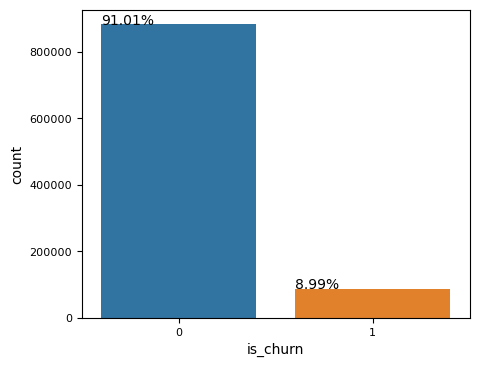

會員流失數和比例 1 : 87330 ( 8.994 %)
會員流失數和比例 0 : 883630 ( 91.006 %)


In [15]:
fig,axes = plt.subplots(figsize=(5,4))
sns.countplot(data=train_member, x=train_member['is_churn'])
plt.xticks(size=8)
plt.yticks(size=8)

total = len(train_member)
for p in axes.patches:
    percentage =  f'{np.round((100 * p.get_height() / total),2)}%'
    x = p.get_x()
    y = p.get_height()
    axes.annotate(f'{percentage}',(x,y), size=10)
plt.show()

#####

is_churn = train_member['is_churn'].value_counts()
is_churn_type = train_member['is_churn'].unique()
annote = '會員流失數和比例'
for i in is_churn_type:
    print(annote, i, ':',is_churn[i],'(',np.round((is_churn[i]/total*100), 3), '%)') 


##### 透過上圖顯示，train_member資料集中有91.01%的非流失用戶、8.99%的流失用戶。可以得知取出的部分是不平衡的資料集。

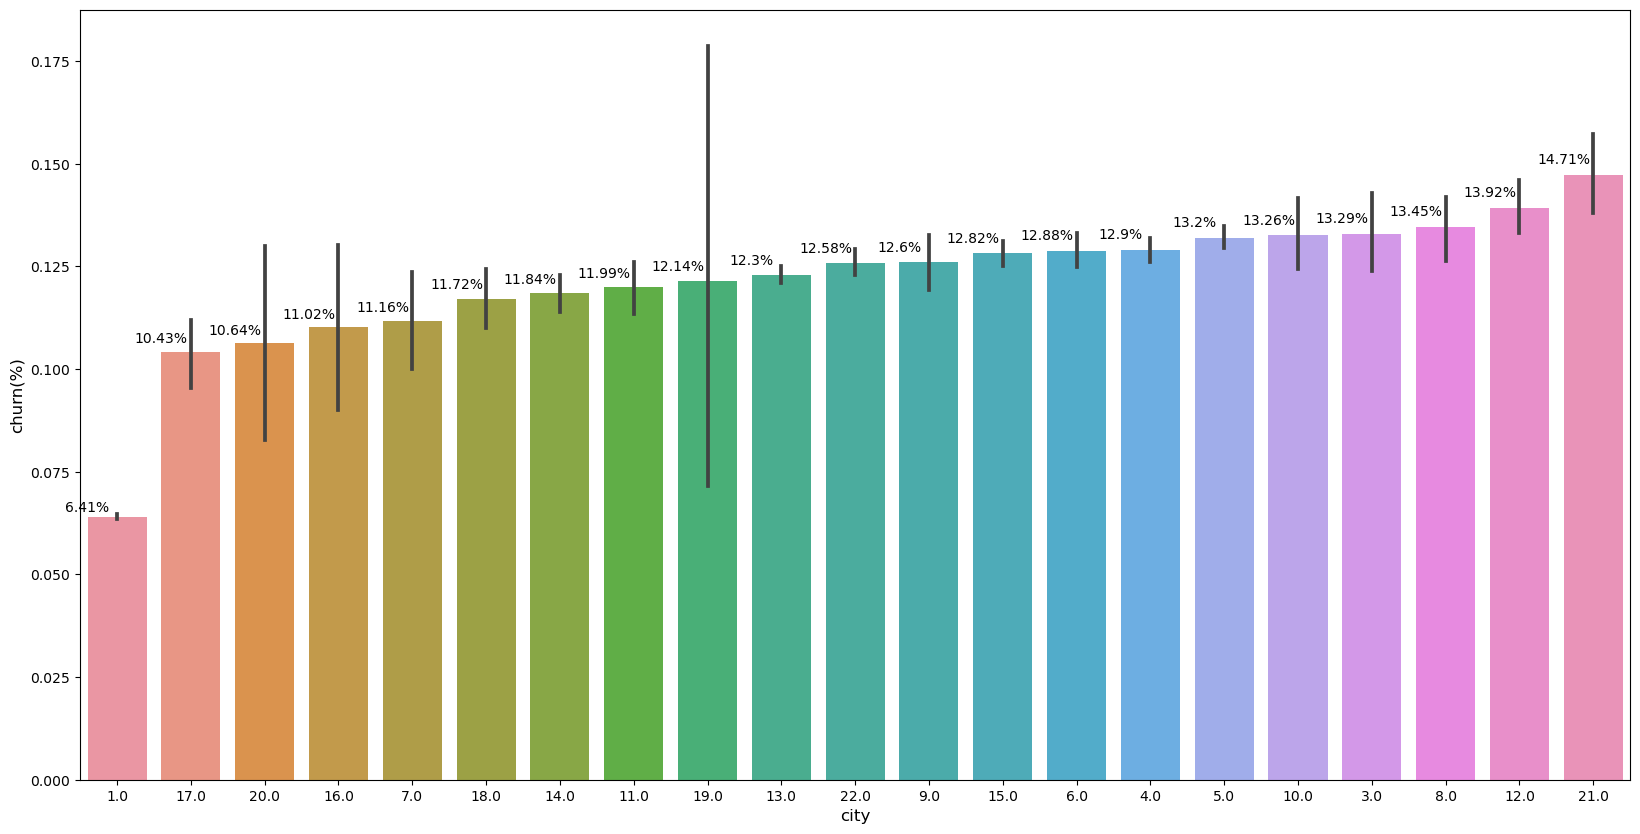

    city  is_churn  total_users  churned_ratio
0    1.0     28351       442598       0.064056
1   17.0       571         5476       0.104273
2   20.0        72          677       0.106352
3   16.0       104          944       0.110169
4    7.0       296         2652       0.111614
5   18.0       913         7792       0.117171
6   14.0      2370        20013       0.118423
7   11.0      1096         9138       0.119939
8   19.0        17          140       0.121429
9   13.0     11950        97136       0.123023
10  22.0      5284        41991       0.125836
11   9.0      1200         9526       0.125971
12  15.0      5538        43187       0.128233
13   6.0      3358        26066       0.128827
14   4.0      6094        47227       0.129036
15   5.0      9333        70706       0.131997
16  10.0       858         6470       0.132612
17   3.0       672         5057       0.132885
18   8.0      1021         7589       0.134537
19  12.0      1585        11383       0.139243
20  21.0     

In [16]:
#城市vs流失：總數和比例(done)
barplot_analysis(data=train_member, col1='city', xname='city', yname='churn(%)',fig=(20,10), col2='is_churn');

In [17]:
# 0~100age 佔的比例? 
age_filter=train_member[(train_member['bd']>0)&(train_member['bd']<=100)]
print(f"Ages between 0~100 : {np.round(len(age_filter) / len(train_member),3)}%")

Ages between 0~100 : 0.398%


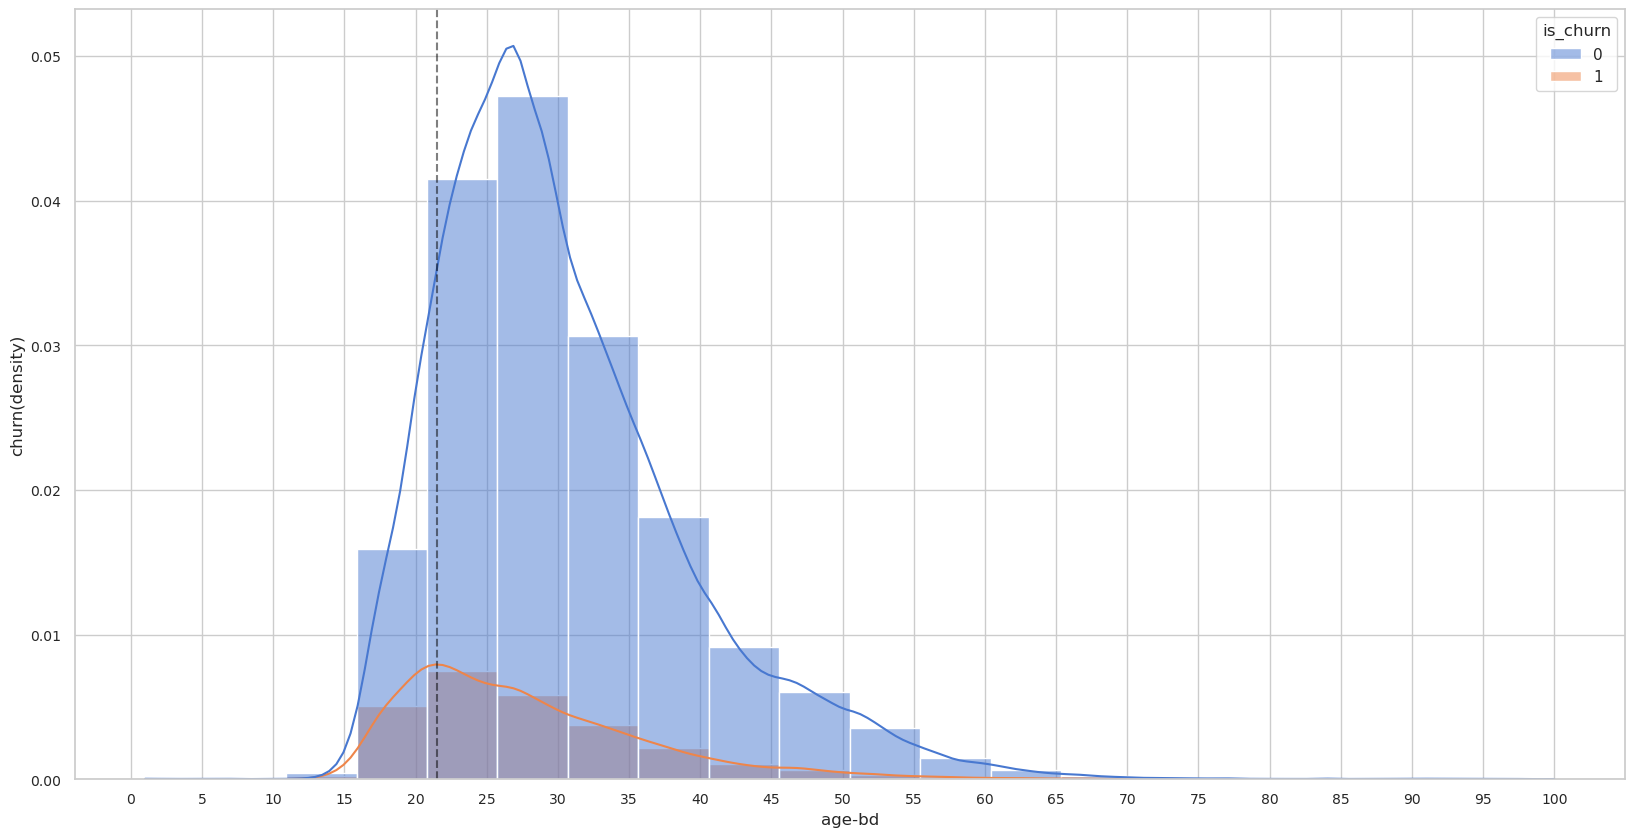

In [18]:
#年齡區間
sns.set(style='whitegrid',palette='muted')
fig,axes = plt.subplots(figsize=(20,10))
#sns.kdeplot(data=age_filter, x=age_filter['bd'], hue=age_filter['is_churn'])
sns.histplot(data=age_filter,x='bd',stat='density',hue='is_churn',kde=True,bins=20,alpha=.5)
axes.set_xticks(np.arange(0, 101, 5))
axes.axvline(21.5,linestyle='dashed',c='black',alpha=.5)
plt.xticks(size=10)
plt.xlabel('age-bd', size=12)
plt.yticks(size=10)
plt.ylabel('churn(density)', size=12);

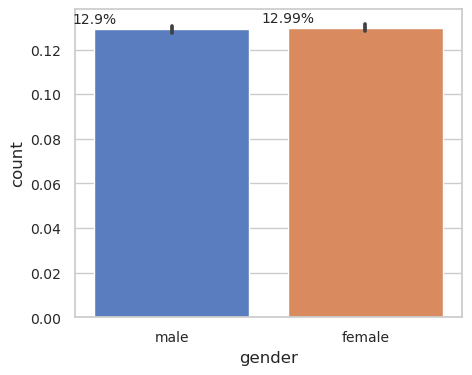

   gender  is_churn  total_users  churned_ratio
0    male     26396       204561       0.129037
1  female     23940       184344       0.129866


In [19]:
#性別vs流失：總數和比例(done)
barplot_analysis(data=train_member, col1='gender', xname='gender', yname='count',fig=(5,4), col2='is_churn');

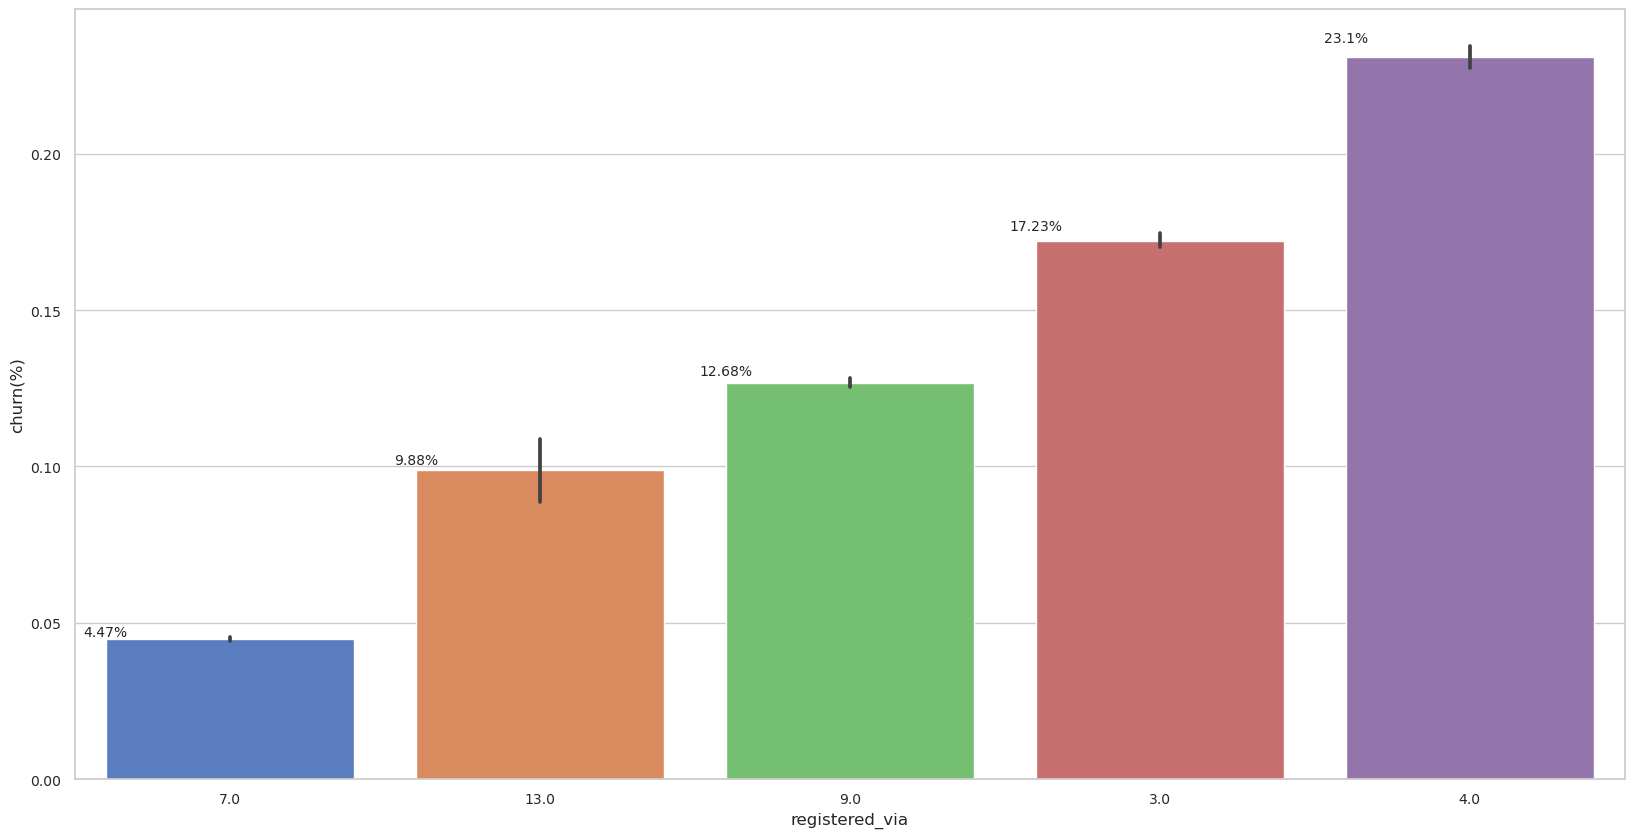

   registered_via  is_churn  total_users  churned_ratio
0             7.0     20697       462684       0.044732
1            13.0       335         3391       0.098791
2             9.0     29893       235689       0.126832
3             3.0     18338       106459       0.172254
4             4.0     12185        52744       0.231022


In [20]:
#註冊方式vs流失：總數和比例(done)
barplot_analysis(data=train_member, col1='registered_via', xname='registered_via', yname='churn(%)',fig=(20,10), col2='is_churn');

In [21]:
#registration_init_time
train_member['format_registration_init_time']=train_member['registration_init_time']
train_member['format_registration_init_time'].fillna('19900101', inplace=True)
train_member['format_registration_init_time'] = train_member['format_registration_init_time'].astype(int).astype(str)

In [22]:
train_member['format_registration_init_time']=pd.to_datetime(train_member['format_registration_init_time'], format='%Y%m%d')

In [23]:
train_member['year'] = train_member['format_registration_init_time'].dt.year

In [24]:
train_member['year'] = train_member['year'].replace(1990,-1)

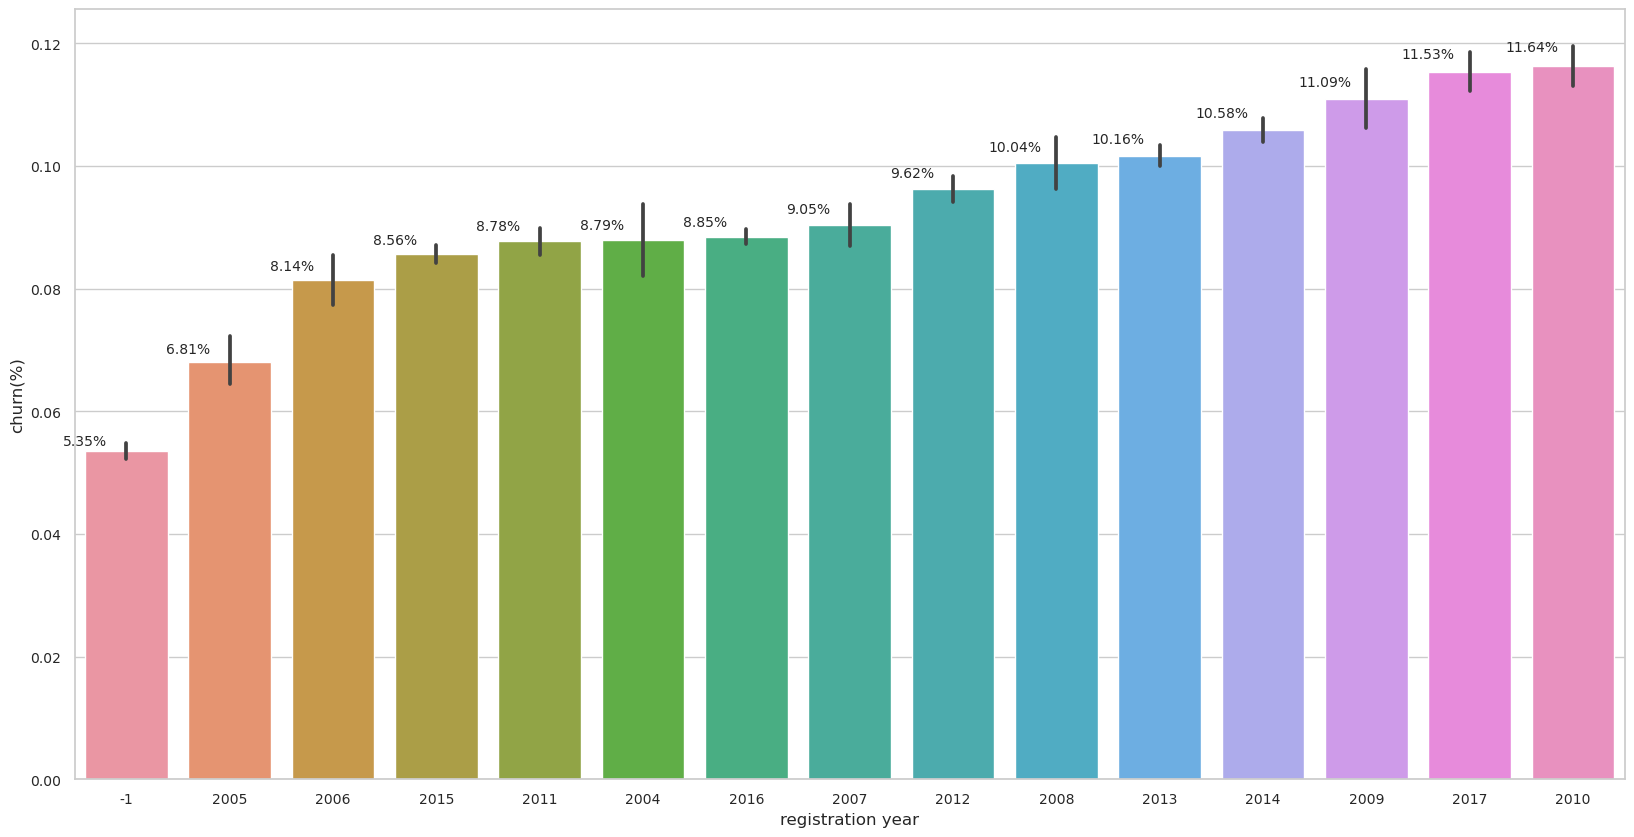

    year  is_churn  total_users  churned_ratio
0     -1      5882       109993       0.053476
1   2005      1063        15616       0.068071
2   2006      1469        18048       0.081394
3   2015     13217       154376       0.085616
4   2011      5332        60698       0.087845
5   2004       732         8330       0.087875
6   2016     17270       195184       0.088481
7   2007      2366        26158       0.090450
8   2012      7168        74495       0.096221
9   2008      1776        17685       0.100424
10  2013     11529       113444       0.101627
11  2014      9452        89332       0.105808
12  2009      1744        15731       0.110864
13  2017      3833        33230       0.115348
14  2010      4497        38640       0.116382


In [25]:
#def barplot_analysis(data, col1, xname, yname, fig, col2):
barplot_analysis(data=train_member,col1='year',xname='registration year',yname='churn(%)',fig=(20,10), col2='is_churn')

##### 每年會員流失率約在 6% ~ 12%，每年的流失率並沒有固定增或減的趨勢。

##### #Feature Engineering# 新增欄位'age'：</br>

In [26]:
train_member['age'] = train_member['bd'].apply(lambda x: 1 if 0 < x <= 22 else 0 if 22 < x <= 100 else -1)
train_member['age'] = train_member['age'].fillna(-1)

##### EDA:Analysis on transactions data

In [27]:
# merging train dataset with transactions dataset and members dataset
train_transaction = df_train.merge(all_df_transaction, on='msno', how='left').merge(train_member[['msno','format_registration_init_time']],on='msno',how='left')

In [28]:
#檢視train_transaction的摘要
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16255622 entries, 0 to 16255621
Data columns (total 11 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   msno                           object        
 1   is_churn                       int64         
 2   payment_method_id              int64         
 3   payment_plan_days              int64         
 4   plan_list_price                int64         
 5   actual_amount_paid             int64         
 6   is_auto_renew                  int64         
 7   transaction_date               int64         
 8   membership_expire_date         int64         
 9   is_cancel                      int64         
 10  format_registration_init_time  datetime64[ns]
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 1.5+ GB


msno                 --> 匿名id<br>
is_churn             --> 是否流失<br>
payment_method_id    --> 使用什麼管道付費<br>
payment_plan_days    --> 訂閱幾天<br>
plan_list_price      --> 該交易的價格<br>
actual_amount_paid   --> 該交易使用者實付多少錢(有時候可能有優惠，會看見 0 )<br>
is_auto_renew        --> 該交易是否是自動更新(KKBOX訂閱時的預設是 "是" )<br>
trans_date           --> 該交易的發生日期<br>
mem_expire_date      --> 該交易的會員到期日<br>
is_cancel            --> 是否為使用者取消(取消不一定代表流失，可能為替換方案)<br>

##### 會員數原有970,960筆，合併交易資料之後增加為16,255,622筆，推測是紀錄會員多次交易的情形。

In [29]:
#把訂單日期轉換成日期格式
train_transaction['format_transaction_date']=pd.to_datetime(train_transaction['transaction_date'], format='%Y%m%d')
train_transaction['transaction_year']=train_transaction['format_transaction_date'].dt.year

In [30]:
train_transaction = train_transaction.sort_values(by=['msno','format_transaction_date'])
train_transaction.head(5)

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,format_registration_init_time,format_transaction_date,transaction_year
12656265,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,20161116,20161215,0,2014-06-08,2016-11-16,2016
12656267,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,20161215,20170115,0,2014-06-08,2016-12-15,2016
12656264,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,20170115,20170215,0,2014-06-08,2017-01-15,2017
12656266,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,20170215,20170315,0,2014-06-08,2017-02-15,2017
12656268,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,20170315,20170415,0,2014-06-08,2017-03-15,2017


In [31]:
#發現+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=這名會員早在2010年就註冊了，消費紀錄卻從2016年開始
train_member[train_member['msno']=='+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=']

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,format_registration_init_time,year,age
798970,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,15.0,26.0,male,9.0,20101118.0,2010-11-18,2010,0


In [32]:
#**進一步觀察會員交易的年份分布
payments_year = train_transaction.groupby('transaction_year').size().reset_index(name='count')
payments_year

,transaction_year,count
0,2015,5025643
1,2016,8405241
2,2017,2824738


##### 會員註冊年份介於2005-2017，但交易年份紀錄集中在 2015-2017，推測是資料採取的方式，接下來可思考的點：</br>
1.訂閱次數與流失率的關係</br>
2.is_cancel=1 的會員於該期取消之後，後續是否有選擇其他方案續約?

In [33]:
#**計算重複交易的筆數比例
payments = train_transaction.groupby('msno').size().reset_index(name='count')
print(f"會員人數： {payments['msno'].count()}")
print(f"交易1次以上： {payments[payments['count']>1]['msno'].count()}")
print(f"只交易1次： {payments[payments['count']==1]['msno'].count()}")

會員人數： 970960
交易1次以上： 963293
只交易1次： 7667


In [34]:
#去掉重複的紀錄，只保留每位會員最後一筆交易資料做為判斷最後是否流失
#(假如會員在3/31續約時取消，若在30天內續約則不視為流失，但資料中我們無法得知3/31後的資訊，因此這邊取最後一筆交易資料)
train_transaction = train_transaction.sort_values(by=['msno','format_transaction_date'],ascending=False)
payments_transaction = train_transaction.merge(payments,on='msno',how='left')
train_transaction_new = payments_transaction.drop_duplicates(subset='msno', keep='first')

In [35]:
#每個會員的交易次數
train_transaction_new['count'].describe()

count    970960.000000
mean         16.741804
std           8.736920
min           1.000000
25%           9.000000
50%          17.000000
75%          24.000000
max         244.000000
Name: count, dtype: float64

In [36]:
train_transaction_new['if_tradeonlyonce'] = train_transaction_new['count'].apply(lambda x:0 if x>1 else 1)

/tmp/ipykernel_2009/2597441053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_transaction_new['if_tradeonlyonce'] = train_transaction_new['count'].apply(lambda x:0 if x>1 else 1)


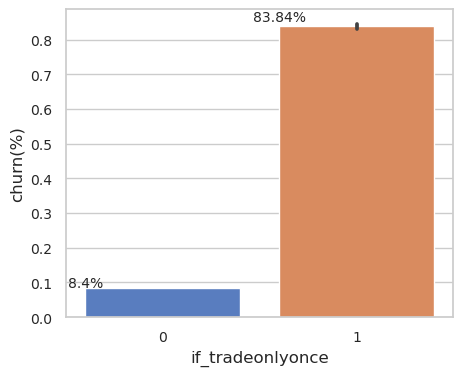

   if_tradeonlyonce  is_churn  total_users  churned_ratio
0                 0     80902       963293       0.083985
1                 1      6428         7667       0.838398


In [37]:
#觀察交易次數vs流失：總數和比例(done)
barplot_analysis(data=train_transaction_new,col1='if_tradeonlyonce',xname='if_tradeonlyonce',yname='churn(%)',fig=(5,4), col2='is_churn')

訂閱兩次以上的人流失率大約是8.4%，而僅訂閱一次的人高達83.84%

##### #Feature Engineering# 新增欄位'after_cancel'：</br>
1.曾經取消又續訂:cancel_continue</br>
2.曾經取消後不續訂(流失):cancel_churn</br>
3.未曾取消:cancel_never

In [38]:
#***篩選出曾經取消後還有再次消費的紀錄→→→→用shift()
#cancel = payments_transaction
payments_transaction['is_cancel_new'] = payments_transaction['is_cancel']+1
payments_transaction['next_tran'] = payments_transaction['is_cancel_new'] - payments_transaction.groupby('msno')['is_cancel_new'].shift(-1)

In [39]:
#1.找出最後一筆next_tran=1 -> 2
#2.排除2的id，剩下的找出有-1的 -> 1
#3.剩下的 -> 3

In [40]:
#找出最後一筆交易 next_tran=1, 代表：2.曾經取消後不續訂(流失)
next_tran_1 = payments_transaction.drop_duplicates(subset = 'msno', keep='first')
next_tran_1 = next_tran_1[next_tran_1['next_tran']==1]
next_tran_1['after_cancel'] = 'cancel_churn'
next_tran_1 = next_tran_1[['msno','after_cancel']]
next_tran_1.head(5)

,msno,after_cancel
79,zzx7wcys2Nha6yP2Skjs+R1/JNAfEuAWUaAp0qsV2Cg=,cancel_churn
638,zznOp14XYH0JZQlyS6D8eereJBwiQOIw6JXkC5bWeLM=,cancel_churn
787,zzlcbpoKog6kvPihC0k0kEP0fN9pRC71yrrtE6BQVdc=,cancel_churn
1110,zzfEMGdiJm9nO5k41mEPRY3weFE4ctutGdd4aF9kIvg=,cancel_churn
1273,zzd39tdgOwpUPj+8YBr++BcS3xCAelGKK/6JXJ6mnp0=,cancel_churn


In [41]:
payments_transaction = payments_transaction.merge(next_tran_1,on='msno',how='left')

In [42]:
#df.loc[(df['first_name'] != 'Bill') & (df['first_name'] != 'Emma'), 'name_match'] = 'Mismatch'  
payments_transaction.loc[(payments_transaction['next_tran']==-1) & (payments_transaction['after_cancel'].isna()),'after_cancel'] = 'cancel_continue'
payments_transaction.loc[(payments_transaction['after_cancel'].isna()),'after_cancel'] = 'cancel_never'

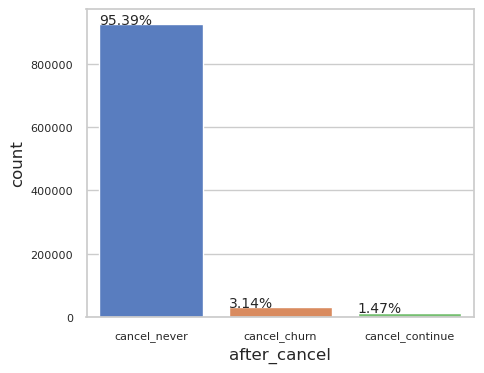

1.曾經取消又續訂(cancel_continue)：14263 人
2.曾經取消後流失(cancel_churn)：30484 人
3.未曾取消(cancel_never)：926213 人


In [43]:
cancel=payments_transaction.drop_duplicates(subset = 'msno', keep='first')
fig,axes = plt.subplots(figsize=(5,4))
axes.yaxis.get_major_formatter().set_scientific(False)
sns.countplot(data=cancel, x=cancel['after_cancel'])
plt.xticks(size=8)
plt.yticks(size=8)

total = len(cancel)
for p in axes.patches:
    percentage =  f'{np.round((100 * p.get_height() / total),2)}%'
    x = p.get_x()
    y = p.get_height()
    axes.annotate(f'{percentage}',(x,y), size=10)
plt.show()

print(f"1.曾經取消又續訂(cancel_continue)：{cancel[cancel['after_cancel']=='cancel_continue']['msno'].count()} 人")
print(f"2.曾經取消後流失(cancel_churn)：{cancel[cancel['after_cancel']=='cancel_churn']['msno'].count()} 人")
print(f"3.未曾取消(cancel_never)：{cancel[cancel['after_cancel']=='cancel_never']['msno'].count()} 人")

##### 到3月為止若會員曾經取消，則有高達68.12%(30484/44747)的比例會流失，後續再將這個特徵OneHot encoding

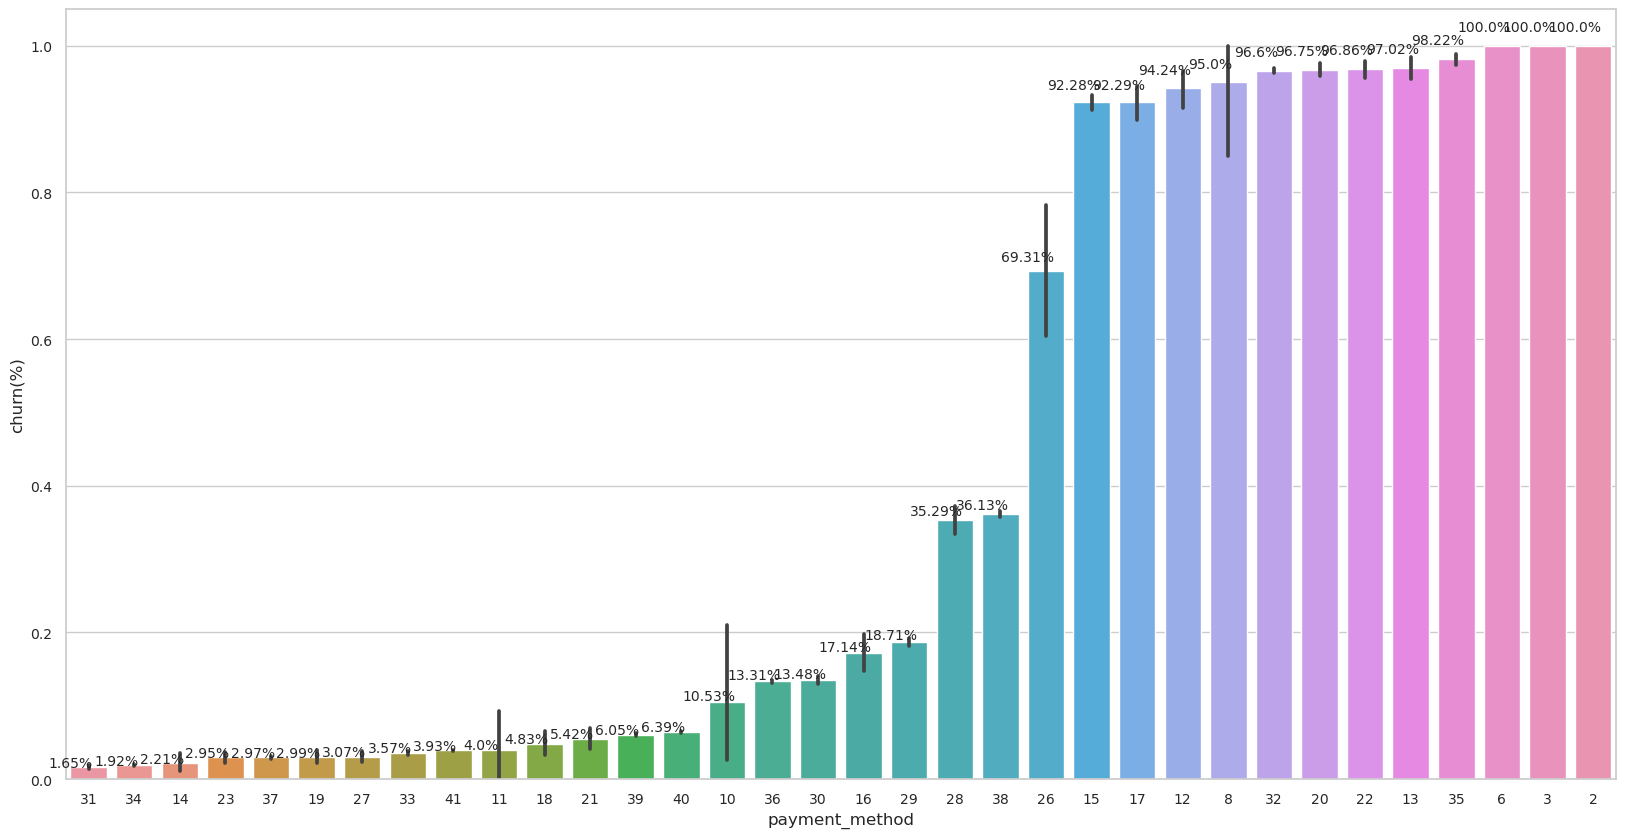

    payment_method_id  is_churn  total_users  churned_ratio
0                  31       170        10321       0.016471
1                  34       551        28716       0.019188
2                  14        12          544       0.022059
3                  23        63         2132       0.029550
4                  37      1099        37045       0.029667
5                  19        39         1303       0.029931
6                  27        56         1826       0.030668
7                  33       505        14165       0.035651
8                  41     21427       544579       0.039346
9                  11         3           75       0.040000
10                 18        31          642       0.048287
11                 21        50          922       0.054230
12                 39      4011        66301       0.060497
13                 40      4718        73871       0.063868
14                 10         4           38       0.105263
15                 36      9827        7

In [44]:
#觀察付費方式vs流失：總數和比例(done)
barplot_analysis(data=train_transaction_new,col1='payment_method_id',xname='payment_method',yname='churn(%)',fig=(20,10), col2='is_churn')

41是最多用戶使用的支付方式，其流失率為3.93%。其他較多人使用的支付方式接續是38,39,40。

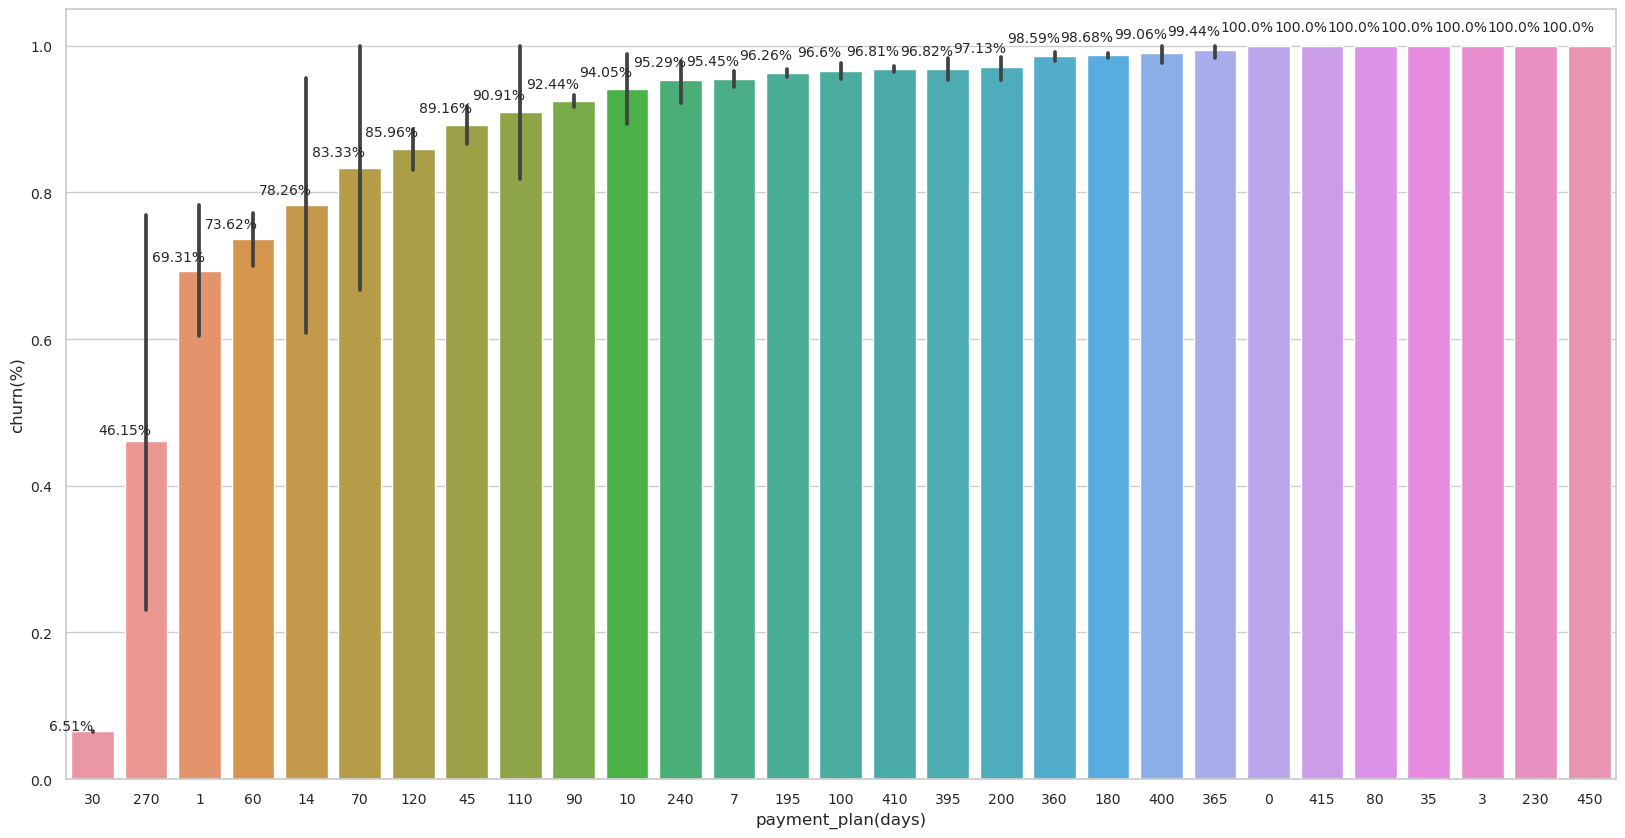

    payment_plan_days  is_churn  total_users  churned_ratio
0                  30     61423       943769       0.065083
1                 270         6           13       0.461538
2                   1        70          101       0.693069
3                  60       441          599       0.736227
4                  14        18           23       0.782609
5                  70        15           18       0.833333
6                 120       508          591       0.859560
7                  45       477          535       0.891589
8                 110        30           33       0.909091
9                  90      3952         4275       0.924444
10                 10        79           84       0.940476
11                240       182          191       0.952880
12                  7      1258         1318       0.954476
13                195      4483         4657       0.962637
14                100      1024         1060       0.966038
15                410      7003         

In [45]:
#方案天數vs流失：總數和比例(done)
barplot_analysis(data=train_transaction_new,col1='payment_plan_days',xname='payment_plan(days)',yname='churn(%)',fig=(20,10), col2='is_churn')

94.29%的用戶選擇訂閱30天的方案，流失率為6.5%，</br>
其餘方案的流失率非常高。

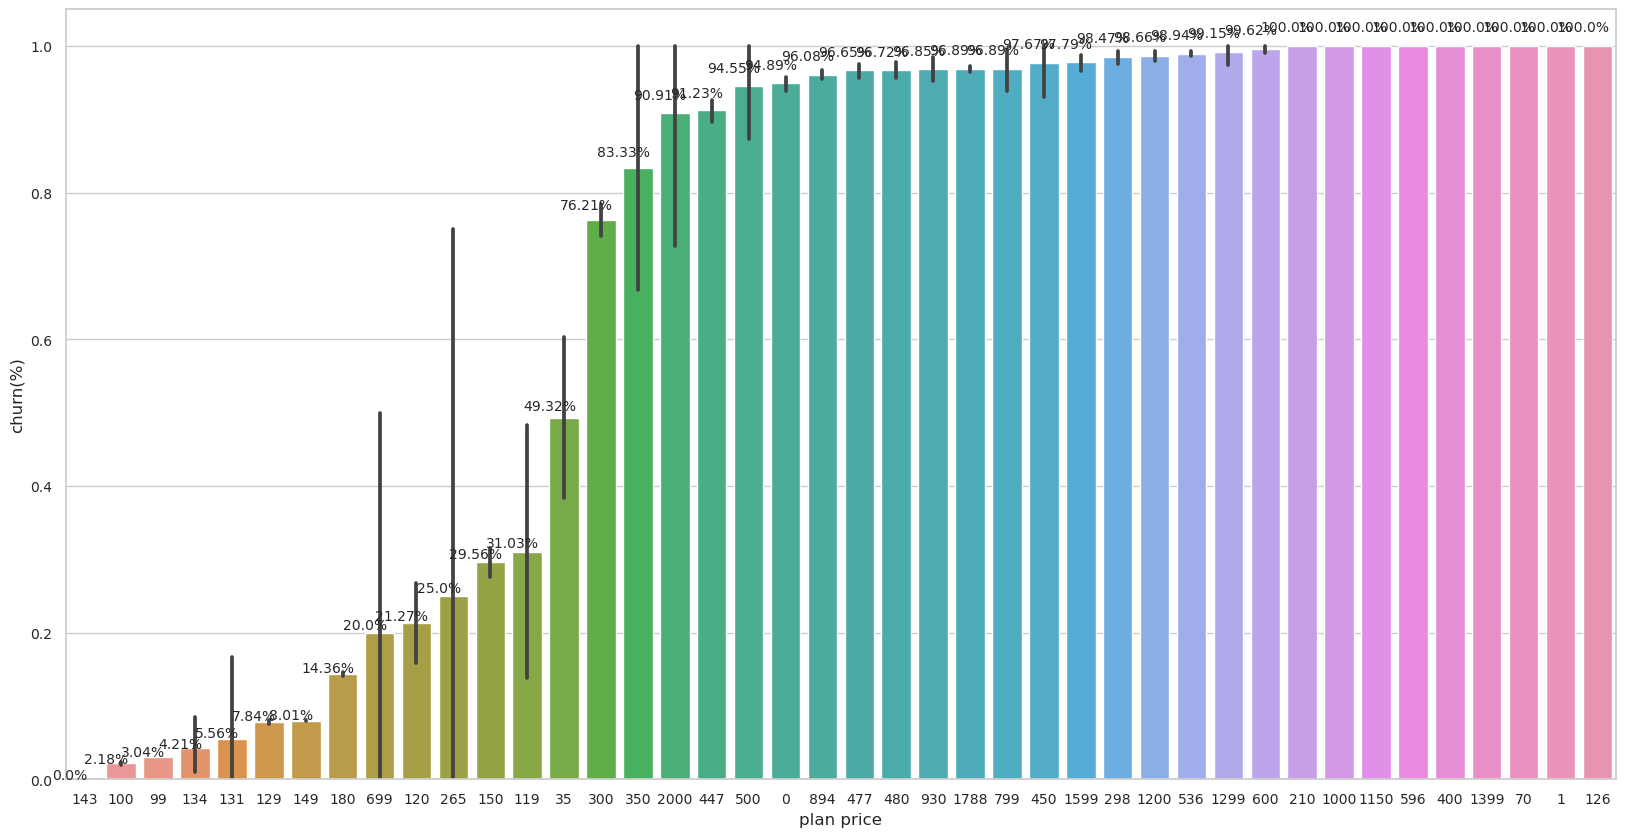

    plan_list_price  is_churn  total_users  churned_ratio
0               143         0            1       0.000000
1               100       647        29736       0.021758
2                99     11161       366947       0.030416
3               134         4           95       0.042105
4               131         1           18       0.055556
5               129      2755        35161       0.078354
6               149     33459       417938       0.080057
7               180     13237        92195       0.143576
8               699         2           10       0.200000
9               120        47          221       0.212670
10              265         1            4       0.250000
11              150       580         1962       0.295617
12              119         9           29       0.310345
13               35        36           73       0.493151
14              300      1163         1526       0.762123
15              350        15           18       0.833333
16            

In [46]:
#方案價格天數vs流失：總數和比例(done)
barplot_analysis(data=train_transaction_new,col1='plan_list_price',xname='plan price',yname='churn(%)',fig=(20,10), col2='is_churn')

所有方案價格有41種，用戶選擇方案的前三名為149、99、180元，合計將近90.33%</br>
其中以99元的流失率3.04%最低。</br>

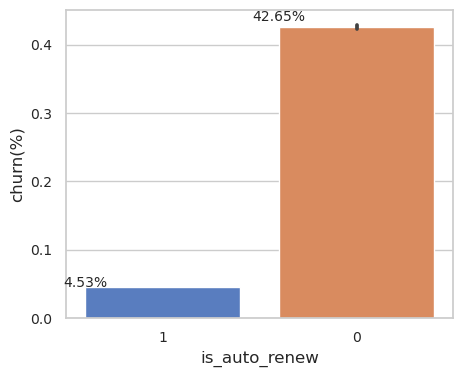

   is_auto_renew  is_churn  total_users  churned_ratio
0              1     38836       857253       0.045303
1              0     48494       113707       0.426482


In [47]:
#是否自動續訂vs流失：總數和比例(done)：
barplot_analysis(data=train_transaction_new,col1='is_auto_renew',xname='is_auto_renew',yname='churn(%)',fig=(5,4), col2='is_churn')

最後一次交易有88.29%的用戶選擇自動續訂(亦為系統預設)，流失率為4.53%</br>
而選擇不自動續訂的用戶流失率則有42.65%

##### #Feature Engineering# 新增欄位'loyalty'：</br>

In [48]:
#將最後訂閱時間 - 註冊時間 作為顧客忠誠的指標
train_transaction_new['loyalty'] = train_transaction_new['format_transaction_date'] - train_transaction_new['format_registration_init_time']
train_transaction_new['loyalty'] = train_transaction_new['loyalty'].astype(str)
train_transaction_new['loyalty'] = train_transaction_new['loyalty'].apply(lambda x: x.split()[0]).astype('int')

In [49]:
train_transaction_new[train_transaction_new['format_registration_init_time']=='1990-01-01']['loyalty'].min()

9468

In [50]:
#-1取代缺失值
train_transaction_new['loyalty'] = train_transaction_new['loyalty'].apply(lambda x: -1 if x >=9468 else x)

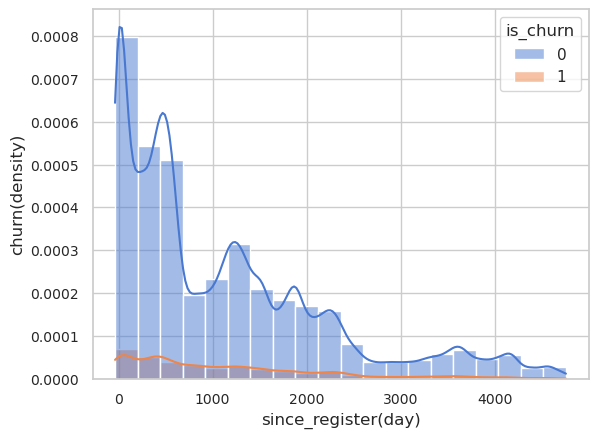

In [51]:
#忠誠vs流失：總數和比例(done)

sns.set(style='whitegrid',palette='muted')
sns.histplot(data=train_transaction_new,x='loyalty',stat='density',hue='is_churn',kde=True,bins=20,alpha=.5)
plt.xticks(size=10)
plt.xlabel('since_register(day)', size=12)
plt.yticks(size=10)
plt.ylabel('churn(density)', size=12);

In [52]:
# 幫'loyalty'區分等級
# train_transaction_new['loyalty_level'] = pd.cut(train_transaction_new['loyalty'], bins=4,labels=[1,2,3,4]).astype(int)

##### EDA:Analysis on user_logs data

In [53]:
#user_logs檔案太大，將資料上傳到BigQuery用SQL進行查詢
%load_ext google.cloud.bigquery

In [54]:
%%bigquery
SELECT *
FROM( 
SELECT * FROM kkbox_data.user_logs
UNION ALL
SELECT *
FROM kkbox_data.user_logs_v2)
GROUP BY msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
HAVING COUNT(*)>1

Query is running:   0%|          |

Downloading: |          |

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs


user_logs,user_logs_v2 兩個表內沒有重複的資料

In [55]:
%%bigquery
WITH all_user_logs AS(
SELECT *
FROM kkbox_data.user_logs
UNION ALL
SELECT *
FROM kkbox_data.user_logs_v2
)

SELECT MIN(date) AS min,MAX(date) AS max
FROM all_user_logs

Query is running:   0%|          |

Downloading:   0%|          |

,min,max
0,20150101,20170331


In [56]:
%%bigquery
WITH all_user_logs AS(
SELECT *
FROM kkbox_data.user_logs
UNION ALL
SELECT *
FROM kkbox_data.user_logs_v2
),
user_logs AS(
SELECT *
FROM all_user_logs
WHERE msno IN (
SELECT msno
FROM kkbox_data.df_train_new)
),
user_outlier_num AS (
SELECT 'num_25' AS Data, APPROX_QUANTILES(num_25,100) AS quant
FROM user_logs
UNION ALL
SELECT 'num_50' AS Data, APPROX_QUANTILES(num_50,100) AS quant
FROM user_logs
UNION ALL 
SELECT 'num_75' AS Data, APPROX_QUANTILES(num_75,100) AS quant 
FROM user_logs       
UNION ALL 
SELECT 'num_985' AS Data, APPROX_QUANTILES(num_985,100) AS quant 
FROM user_logs       
UNION ALL
SELECT 'num_100' AS Data, APPROX_QUANTILES(num_100,100) AS quant 
FROM user_logs       
UNION ALL
SELECT 'num_unq' AS Data, APPROX_QUANTILES(num_unq,100) AS quant 
FROM user_logs),
user_outlier_secs AS(
SELECT 'total_secs' AS Data, APPROX_QUANTILES(total_secs,100) AS quant_secs 
FROM user_logs),
user_outlier AS(
SELECT Data,CASE WHEN (quant[OFFSET(25)]-1.5*(quant[OFFSET(75)] - quant[OFFSET(25)]))<0 THEN 0 END AS secs_Lower_limit,
       quant[OFFSET(75)]+1.5*(quant[OFFSET(75)] - quant[OFFSET(25)]) AS secs_Upper_limit
FROM user_outlier_num
UNION ALL
SELECT Data,CASE WHEN (quant_secs[OFFSET(25)]-1.5*(quant_secs[OFFSET(75)] - quant_secs[OFFSET(25)]))<0 THEN 0 END AS secs_Lower_limit,
       quant_secs[OFFSET(75)]+1.5*(quant_secs[OFFSET(75)] - quant_secs[OFFSET(25)]) AS secs_Upper_limit
FROM user_outlier_secs
)

SELECT *
FROM user_outlier

#從user_log中篩選出df_train_new的用戶，使用bigquery語法計算分位數 quantile(<expression>, 2)，找出outlier

Query is running:   0%|          |

Downloading:   0%|          |

,Data,secs_Lower_limit,secs_Upper_limit
0,num_50,0,5.0000
1,num_75,0,2.5000
2,num_25,0,17.5000
3,num_unq,0,94.0000
4,total_secs,0,24708.5975
5,num_985,0,2.5000
6,num_100,0,92.0000


In [57]:
%%bigquery
WITH all_user_logs AS(
SELECT *
FROM kkbox_data.user_logs
UNION ALL
SELECT *
FROM kkbox_data.user_logs_v2
),
user_logs AS(
SELECT *
FROM all_user_logs
WHERE msno IN (
SELECT msno
FROM kkbox_data.df_train_new)
)
SELECT COUNT(*) AS total, AVG(num_25) AS avg_25, AVG(num_50) AS avg_50, AVG(num_75) AS avg_75, AVG(num_985) AS avg_985,
AVG(num_100) AS avg_100, AVG(num_unq) AS avg_unq, AVG(total_secs) AS ts,
FROM user_logs
WHERE (num_25 BETWEEN 0 AND 17.5)
AND (num_50 BETWEEN 0 AND 5)
AND (num_75 BETWEEN 0 AND 2.5)
AND (num_985 BETWEEN 0 AND 2.5)
AND (num_100 BETWEEN 0 AND 92)
AND (num_unq BETWEEN 0 AND 94)
AND (total_secs BETWEEN 0 AND 24720.068);

Query is running:   0%|          |

Downloading:   0%|          |

,total,avg_25,avg_50,avg_75,avg_985,avg_100,avg_unq,ts
0,41975272,2.736436,0.696252,0.43037,0.447892,19.694492,18.931334,5116.17928


去掉outlier剩下41,975,272筆資料，聽歌的狀況以整首聽完為主，每個人每日大約會聽17首歌，做為後續Feature Engineering使用。

##### Feature Engineering# 新增欄位'user_immerse'：</br>
(num_100歌曲數 / 總聽歌曲數)

In [58]:
#(train)user_immersel
sql = """
WITH all_user_logs AS(
SELECT *
FROM kkbox_data.user_logs
UNION ALL
SELECT *
FROM kkbox_data.user_logs_v2
),
user_logs AS(
SELECT *
FROM all_user_logs
WHERE msno IN (
SELECT msno
FROM kkbox_data.train_v2)
),
day_listen_immerse AS(
SELECT msno, ( num_100 / (num_25 + num_50 + num_75 + num_985 + num_100) ) AS singleday_immerse
FROM user_logs
),
listen_immerse AS(
SELECT msno, AVG(singleday_immerse) AS user_immerse
FROM day_listen_immerse
GROUP BY msno)

SELECT *
FROM listen_immerse
"""

train_immerse = bigquery_client.query(sql).to_dataframe()
train_immerse.head()

,msno,user_immerse
0,eVoBgmu78HK10tIV6dBr76nvKdi/3rfXFRi8ITxFCa8=,0.750825
1,8C3tspLRErdg3Vj+yxNlVUcEFSZySryyNYNsdlX6rjA=,0.491725
2,s4fcm29Z0Rsba6fx4G33jcuNkUWjbKkdIl9UL/6y4ME=,0.749083
3,TUsdZAt9wZ4RUg0fq+WSI6LzrE90wgjDO/dlYfMs7m8=,0.654838
4,xVwngkWs2V2apAC3ZmtFrkZN4+8MRIj3uakQZYE+4Lc=,0.882216


In [59]:
#(test)user_immersel
sql = """
WITH all_user_logs AS(
SELECT *
FROM kkbox_data.user_logs
UNION ALL
SELECT *
FROM kkbox_data.user_logs_v2
),
user_logs AS(
SELECT *
FROM all_user_logs
WHERE msno IN (
SELECT msno
FROM kkbox_data.submission)
),
day_listen_immerse AS(
SELECT msno, ( num_100 / (num_25 + num_50 + num_75 + num_985 + num_100) ) AS singleday_immerse
FROM user_logs
),
listen_immerse AS(
SELECT msno, AVG(singleday_immerse) AS user_immerse
FROM day_listen_immerse
GROUP BY msno)

SELECT *
FROM listen_immerse
"""

test_immerse = bigquery_client.query(sql).to_dataframe()
test_immerse.head()

,msno,user_immerse
0,O7P96MhhdAh3MMaucB0D2SpPBwHfmRH5EhAibfrV27w=,0.566714
1,WJ5Jpo5G9BBw0aOxyY0a2G5CsKQS2hbSTBVFSTgDNbM=,0.838474
2,FwcNSREU4waHvkkdm8FlVyYoZxnMYCqDA39umsac/8U=,0.806612
3,8MMYrmcsJlPdWnv90+qlDUbHOoUa1k9QNRxo3XhFIrQ=,0.686540
4,NvhKRomofKzjPO9OK3aRl4puGM0rJ9VZcGYDdGKlHqA=,0.761829


##### Feature Engineering# 新增欄位'total_listen_day'：</br>
(會員總聽歌天數)

In [60]:
#(train)計算會員總聽歌天數
sql = """
WITH all_user_logs AS(
SELECT *
FROM kkbox_data.user_logs
UNION ALL
SELECT *
FROM kkbox_data.user_logs_v2
),
train_user_logs AS(
SELECT *
FROM all_user_logs
WHERE msno IN (
SELECT msno
FROM kkbox_data.train_v2)
)

SELECT msno, COUNT(msno) AS total_listen_day
FROM train_user_logs
GROUP BY msno
"""

train_total_listen_day = bigquery_client.query(sql).to_dataframe()
train_total_listen_day.head()

,msno,total_listen_day
0,bndDXWeAWg1ivtFhdIF8wvB81VUG8in2KSfZ29giAko=,235
1,xBWIP4nVFjLNizHH0Yr63dtp2/2qD7wmh3J+vWi/qD0=,226
2,j1UgEjWPQxPQ/8x4f7ObyqeBiN7LHWcEI7mBOx8GXMg=,246
3,m5LFh/ETiQGmI/bRoBQQvDSbZm5ONkT43Qkiisid7wE=,169
4,dMp9bx5N5vAhWVNr/0001p3hLBL8V80ChPFHMnEJdfA=,132


In [61]:
#(test)計算會員總聽歌天數
sql = """
WITH all_user_logs AS(
SELECT *
FROM kkbox_data.user_logs
UNION ALL
SELECT *
FROM kkbox_data.user_logs_v2
),
test_user_logs AS(
SELECT *
FROM all_user_logs
WHERE msno IN (
SELECT msno
FROM kkbox_data.submission)
)

SELECT msno, COUNT(msno) AS total_listen_day
FROM test_user_logs
GROUP BY msno
"""

test_total_listen_day = bigquery_client.query(sql).to_dataframe()
test_total_listen_day.head()

,msno,total_listen_day
0,zQTBTGF2uByzOrm6CPc/eYtK+SZwOFIGyHkr4xf9qxo=,410
1,0qiEgJznHZn1GMu3nwZWBN/CFwVGJ7gUTW0N4VZAPxk=,201
2,qlI5It9B9WORY69XqoHeiVvtg9ZQWQSYUqHsBYJkR/k=,41
3,fqzhok20g6iNUZf/KizN+j5RNaOsm7CKKo6YgdRohxw=,216
4,SsoaMd0vAmkaIl9pxXVUEf1cJD9XDGsh0AxfBtbpLCE=,509


##### Data Preprocessing

In [62]:
# train_member
# cancel
# train_immerse
# train_total_listen_day

# sub_member
# test_immerse
# test_total_listen_day

In [63]:
#彙整train_dataset使用到的資料集、挑選需要的欄位、補缺值
train_member_select = train_member[['msno','is_churn','age','registered_via']]

cancel_select = cancel[['msno','after_cancel']]

train_transaction_new_select = train_transaction_new[['msno','payment_method_id','is_auto_renew','count','loyalty']]

In [64]:
train_dataset = train_member_select.merge(cancel_select,on='msno').merge(train_transaction_new_select,on='msno')\
.merge(train_immerse,on='msno',how='left').merge(train_total_listen_day,on='msno',how='left')

In [65]:
train_dataset.isnull().sum()

msno                      0
is_churn                  0
age                       0
registered_via       109993
after_cancel              0
payment_method_id         0
is_auto_renew             0
count                     0
loyalty                   0
user_immerse         115800
total_listen_day     115800
dtype: int64

In [66]:
# train_dataset['gender'] = train_dataset['gender'].replace('male',1)
# train_dataset['gender'] = train_dataset['gender'].replace('female',0)
# train_dataset['gender'] = train_dataset['gender'].fillna(-1)
train_dataset['registered_via'] = train_dataset['registered_via'].fillna(-1)
train_dataset['user_immerse'] = train_dataset['user_immerse'].fillna(-1)
train_dataset['total_listen_day'] = train_dataset['total_listen_day'].fillna(-1)

In [67]:
# Use dummy variables for registration after_cancel
train_dataset = pd.get_dummies(train_dataset, columns=['after_cancel'])

In [68]:
# splits train and validation set
X_train = train_dataset.drop(labels=['msno','is_churn'],axis=1)
y_train = train_dataset['is_churn']

In [69]:
# X_train = train_dataset[['payment_method_id','is_auto_renew','user_immerse']]
# y_train = train_dataset['is_churn']

處理df_submission_2，建立test_dataset

In [70]:
#df_submission合併members
sub_member = df_submission.merge(df_member,on='msno',how='left')

In [71]:
sub_member['age'] = sub_member['bd'].apply(lambda x: 1 if 0 < x <= 22 else 0 if 22 < x <= 100 else -1)
sub_member['age'] = sub_member['age'].fillna(-1)

In [72]:
sub_member['format_registration_init_time']=sub_member['registration_init_time']
sub_member['format_registration_init_time'].fillna('19900101', inplace=True)
sub_member['format_registration_init_time'] = sub_member['format_registration_init_time'].astype(int).astype(str)

sub_member['format_registration_init_time']=pd.to_datetime(sub_member['format_registration_init_time'], format='%Y%m%d')

=====

In [73]:
#df_submission合併transaction,merbers
sub_transaction = df_submission.merge(all_df_transaction, on='msno', how='left').merge(sub_member[['msno','format_registration_init_time']],on='msno',how='left')

In [74]:
#把訂單日期轉換成日期格式
sub_transaction['format_transaction_date']=pd.to_datetime(sub_transaction['transaction_date'], format='%Y%m%d')

In [75]:
#計算重複交易的筆數比例
sub_payments = sub_transaction.groupby('msno').size().reset_index(name='count')
print(f"會員人數： {sub_payments['msno'].count()}")
print(f"交易1次以上： {sub_payments[sub_payments['count']>1]['msno'].count()}")
print(f"只交易1次： {sub_payments[sub_payments['count']==1]['msno'].count()}")

會員人數： 907471
交易1次以上： 874763
只交易1次： 32708


In [76]:
sub_transaction = sub_transaction.sort_values(by=['msno','format_transaction_date'],ascending=False)
sub_payments_transaction = sub_transaction.merge(sub_payments,on='msno',how='left')
sub_transaction_new = sub_payments_transaction.drop_duplicates(subset = 'msno', keep='first')

In [77]:
#新增欄位'after_cancel'：1.曾經取消又續訂:cancel_continue 2.曾經取消後不續訂(流失):cancel_churn 3.未曾取消:cancel_never
#***篩選出曾經取消後還有再次消費的紀錄→→→→用shift()
sub_payments_transaction['is_cancel_new'] = sub_payments_transaction['is_cancel']+1
sub_payments_transaction['next_tran'] = sub_payments_transaction['is_cancel_new'] - sub_payments_transaction.groupby('msno')['is_cancel_new'].shift(-1)

In [78]:
#找出最後一筆交易 next_tran=1, 代表：2.曾經取消後不續訂(流失)
sub_next_tran_1 = sub_payments_transaction.drop_duplicates(subset = 'msno', keep='first')
sub_next_tran_1 = sub_next_tran_1[sub_next_tran_1['next_tran']==1]
sub_next_tran_1['after_cancel'] = 'cancel_churn'
sub_next_tran_1 = sub_next_tran_1[['msno','after_cancel']]

In [79]:
#把after_cancel欄位合併sub_payments_transaction(交易總表)，再補入：曾經取消後不續訂(流失):cancel_churn、未曾取消:cancel_never
sub_payments_transaction = sub_payments_transaction.merge(sub_next_tran_1,on='msno',how='left')

sub_payments_transaction.loc[(sub_payments_transaction['next_tran']==-1) & (sub_payments_transaction['after_cancel'].isna()),'after_cancel'] = 'cancel_continue'
sub_payments_transaction.loc[(sub_payments_transaction['after_cancel'].isna()),'after_cancel'] = 'cancel_never'

sub_cancel = sub_payments_transaction.drop_duplicates(subset='msno', keep='first')

In [80]:
#將最後訂閱時間 - 註冊時間 作為顧客忠誠的指標
sub_transaction_new['loyalty'] = sub_transaction_new['format_transaction_date'] - sub_transaction_new['format_registration_init_time']
sub_transaction_new['loyalty'] = sub_transaction_new['loyalty'].astype(str)
sub_transaction_new['loyalty'] = sub_transaction_new['loyalty'].apply(lambda x: x.split()[0]).astype('int')

In [81]:
sub_transaction_new[sub_transaction_new['format_registration_init_time']=='1990-01-01']['loyalty'].min()

9468

In [82]:
#sub_transaction_new[sub_transaction_new['format_registration_init_time']=='1990-01-01']['loyalty'].min()

#-1取代缺失值
sub_transaction_new['loyalty'] = sub_transaction_new['loyalty'].apply(lambda x: -1 if x >=9468 else x)

In [83]:
#sub_transaction_new['loyalty_level'] = pd.cut(sub_transaction_new['loyalty'], bins=4,labels=[1,2,3,4]).astype(int)

In [84]:
#彙整test_dataset使用到的資料集、挑選需要的欄位、補缺值
sub_member_select = sub_member[['msno','age','registered_via']]

sub_cancel_select = sub_cancel[['msno','after_cancel']]

sub_transaction_new_select = sub_transaction_new[['msno','payment_method_id','is_auto_renew','count','loyalty']]

In [85]:
test_dataset = sub_member_select.merge(sub_cancel_select,on='msno',how='left').merge(sub_transaction_new_select,on='msno',how='left')\
.merge(test_immerse,on='msno',how='left').merge(test_total_listen_day,on='msno',how='left')

In [86]:
test_dataset.isnull().sum()

msno                      0
age                       0
registered_via       112381
after_cancel              0
payment_method_id         0
is_auto_renew             0
count                     0
loyalty                   0
user_immerse         119111
total_listen_day     119111
dtype: int64

In [87]:
# test_dataset['gender'] = test_dataset['gender'].replace('male',1)
# test_dataset['gender'] = test_dataset['gender'].replace('female',0)
# test_dataset['gender'] = test_dataset['gender'].fillna(-1)
test_dataset['registered_via'] = test_dataset['registered_via'].fillna(-1)
test_dataset['user_immerse'] = test_dataset['user_immerse'].fillna(-1)
test_dataset['total_listen_day'] = test_dataset['total_listen_day'].fillna(-1)

In [88]:
# Use dummy variables for after_cancel
test_dataset = pd.get_dummies(test_dataset, columns=['after_cancel'])

In [89]:
# splits train and validation set
X_test = test_dataset.drop(labels=['msno'],axis=1)

##### Modeling

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import log_loss, make_scorer

In [97]:
# Various hyper-parameters to tune

cv_params = {   
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'min_child_weight':range(1,10),
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],  
}

other_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'objective':'binary:logistic',
    'missing': -1,
    'random_state': 42
}

xgbModel = xgb.XGBClassifier(**other_params, tree_method='gpu_hist', predictor='gpu_predictor')
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True, labels=[0, 1])
gsearch = GridSearchCV(estimator=xgbModel, param_grid=cv_params, cv=5, scoring=LogLoss, n_jobs=-1)
gsearch.fit(X_train,y_train)

In [ ]:
print('最佳參數：', gsearch.best_params_)
print('最佳模型分數:', gsearch.best_score_)
print(gsearch.best_estimator_)

最佳參數： {'colsample_bytree': 0.6, 'gamma': 2, 'learning_rate': 0.02, 'min_child_weight': 2, 'subsample': 0.6}</br>
最佳模型分數: -0.2343671265991952</br>
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=-1, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=42, ...)

In [91]:
# Separate data into training and validation sets
X = train_dataset.drop(labels=['msno','is_churn'],axis=1)
y = train_dataset['is_churn']

In [92]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
xgb_model = xgb.XGBClassifier(n_estimators=200,learning_rate=0.02,max_depth=5,\
                              min_child_weight=2,subsample=0.6,colsample_bytree=0.6,gamma=2,objective='binary:logistic',eval_metric='logloss',missing=-1, n_jobs=-1)
# Fit the model
xgb_model.fit(X_train,y_train,early_stopping_rounds=10,eval_set=[(X_val, y_val)],verbose=False)

/home/liangyumailbox/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=2, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=-1,
              monotone_constraints=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [94]:
xgb_model_probs = xgb_model.predict_proba(X_val)
logloss = log_loss(y_val,xgb_model_probs[:,1])
logloss

0.1370689185093881

In [105]:
predsTest = xgb_model.predict_proba(X_test)

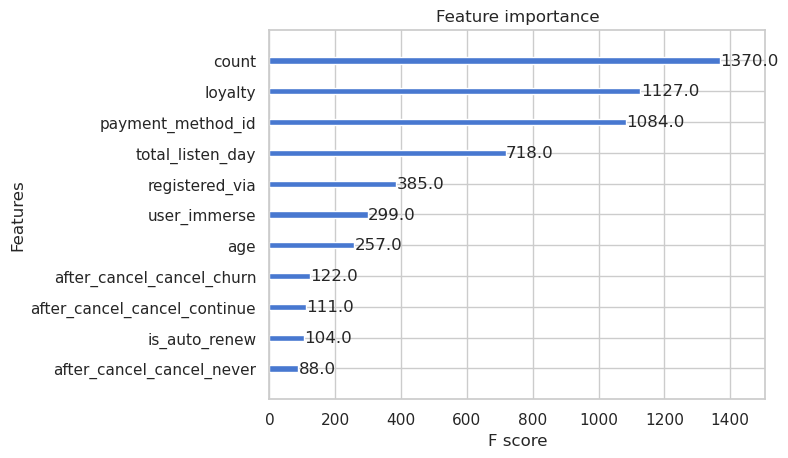

In [95]:
from xgboost import plot_importance
plot_importance(xgb_model)
plt.show()

In [107]:
submission_0 = pd.DataFrame({'is_churn':predsTest[:,1]})
submission = df_submission.drop(labels=['is_churn'],axis=1)
submission = pd.concat([submission,submission_0],axis=1)

In [108]:
submission.to_csv('gs://0-kkbox_bucket/submission.csv', index=False)

In [ ]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
bayes_cv_tuner = BayesSearchCV(estimator = xgb.XGBClassifier(
                                n_estimators = 1600,
                                objective = 'binary:logistic',
                                eval_metric = 'logloss',
                                tree_method='approx'),
    search_spaces = {
        'learning_rate': (0.01, 0.1, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 10),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'scale_pos_weight': (1, 15, 'uniform')
        'gamma': (1e-6, 0.5, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42),
    n_jobs = -1,
    n_iter = 100,   
    verbose = 0,
    refit = True,
    random_state = 42
                              )
          
result = bayes_cv_tuner.fit(X_train, y_train)

In [ ]:
all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
best_params = pd.Series(bayes_cv_tuner.best_params_)
print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
    len(all_models),
    np.round(bayes_cv_tuner.best_score_, 4),
    bayes_cv_tuner.best_params_
    ))

In [117]:
train_dataset.to_csv('gs://0-kkbox_bucket/train_dataset.csv')
test_dataset.to_csv('gs://0-kkbox_bucket/test_dataset.csv')